In [11]:
import os
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from glob import glob
from tslearn import barycenters
from scipy.stats import wasserstein_distance

# Add rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [12]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(cowplot)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [13]:
# load pyspi SPI info
pyspi_SPI_info = pd.read_csv("../feature_extraction/pyspi_SPI_info.csv")

# Define path for derivatives directory
deriv_dir = "/Users/abry4213/data/Cogitate_MEG/derivatives"

# Initialize list for pyspi results
all_pyspi_barycenter_res_averaged_epochs_list = []

# Load pyspi results -- update to where you have stored your pyspi results
pyspi_res_path_averaged = f"{deriv_dir}/time_series_features/averaged_epochs"

# Load in pyspi results
# for pyspi_res_file in os.listdir(pyspi_res_path_averaged):
for pyspi_barycenter_res_file in glob(f"{pyspi_res_path_averaged}/*pyspi_barycenter_sq*.csv"):
    pyspi_barycenter_res_averaged = pd.read_csv(pyspi_barycenter_res_file)
    all_pyspi_barycenter_res_averaged_epochs_list.append(pyspi_barycenter_res_averaged)

# Specifically filter to bary_euclidean
all_pyspi_barycenter_res_averaged_epochs = pd.concat(all_pyspi_barycenter_res_averaged_epochs_list)
# Separate SPI by whether it ends with _max or _max_time
all_pyspi_barycenter_res_averaged_epochs['SPI_stat'] = np.where(all_pyspi_barycenter_res_averaged_epochs['SPI'].str.contains('_max_time'), 'max_time', 'max')
all_pyspi_barycenter_res_averaged_epochs['SPI'] = all_pyspi_barycenter_res_averaged_epochs['SPI'].str.replace('_max_time', '').str.replace('_max', '')

bary_sq_euclidean_res_averaged_epochs = (all_pyspi_barycenter_res_averaged_epochs
                                         .query("SPI=='bary-sq_euclidean' & relevance_type != 'Relevant target'")
                                         )

# Case study: Barycenter visualization for two subjects

### Visualizing the squared barycenter with Euclidean distance [mean] SPI

In [14]:
# Extract the time series for this subject
sub_CB038_time_series = pd.read_csv(f"{deriv_dir}/MEG_time_series/sub-CB038_ses-1_meg_1000ms_all_time_series.csv")
sub_CB038_time_series_of_interest = sub_CB038_time_series.query("relevance_type == 'Irrelevant' & stimulus_type in ['face', 'False'] & times >= 0.0 & times < 1")

# Compute the CS <--> IPS barycenter with Euclidean distance

# False stimuli
sub_CB038_CS_false = sub_CB038_time_series_of_interest.query("stimulus_type == 'False'").Category_Selective.values
sub_CB038_IPS_false = sub_CB038_time_series_of_interest.query("stimulus_type == 'False'").IPS.values
# z-score the time series
sub_CB038_CS_false = (sub_CB038_CS_false - sub_CB038_CS_false.mean()) / sub_CB038_CS_false.std()
sub_CB038_IPS_false = (sub_CB038_IPS_false - sub_CB038_IPS_false.mean()) / sub_CB038_IPS_false.std()
sub_CB038_false_barycenter = barycenters.euclidean_barycenter([sub_CB038_CS_false, sub_CB038_IPS_false])

# Face stimuli
sub_CB038_CS_face = sub_CB038_time_series_of_interest.query("stimulus_type == 'face'").Category_Selective.values
sub_CB038_IPS_face = sub_CB038_time_series_of_interest.query("stimulus_type == 'face'").IPS.values
# z-score the time series
sub_CB038_CS_face = (sub_CB038_CS_face - sub_CB038_CS_face.mean()) / sub_CB038_CS_face.std()
sub_CB038_IPS_face = (sub_CB038_IPS_face - sub_CB038_IPS_face.mean()) / sub_CB038_IPS_face.std()
sub_CB038_face_barycenter = barycenters.euclidean_barycenter([sub_CB038_CS_face, sub_CB038_IPS_face])

# Flatten the barycenter arrays from (1000,1) to (1000,)
sub_CB038_false_barycenter = sub_CB038_false_barycenter.flatten()
sub_CB038_face_barycenter = sub_CB038_face_barycenter.flatten()

# Square the barycenter arrays
sub_CB038_false_barycenter_sq = np.square(sub_CB038_false_barycenter)
sub_CB038_face_barycenter_sq = np.square(sub_CB038_face_barycenter)

# Print the mean squared barycenter for face vs false
print("Mean squared barycenter for face stimuli: ", np.mean(sub_CB038_face_barycenter_sq))
print("Mean squared barycenter for false stimuli: ", np.mean(sub_CB038_false_barycenter_sq))

Mean squared barycenter for face stimuli:  0.2970573114719432
Mean squared barycenter for false stimuli:  0.5944635036343306


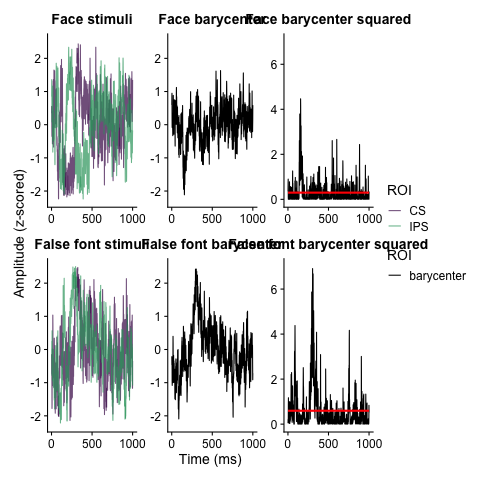

In [15]:
%%R -i sub_CB038_false_barycenter,sub_CB038_face_barycenter,sub_CB038_false_barycenter_sq,sub_CB038_face_barycenter_sq,sub_CB038_CS_face,sub_CB038_IPS_face,sub_CB038_CS_false,sub_CB038_IPS_false

# Plot time series vs barycenter for face
face_barycenter_ts_p <- data.frame(times=1:length(sub_CB038_face_barycenter_sq), IPS = sub_CB038_IPS_face,
           CS = sub_CB038_CS_face) %>%
    pivot_longer(cols=c("IPS", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line(alpha=0.7) +
    ggtitle("Face stimuli") 

# Plot barycenter only for face
face_barycenter_p <- data.frame(times=1:length(sub_CB038_face_barycenter), 
                                value = sub_CB038_face_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line() +
    ggtitle("Face barycenter")

# Plot barycenter squared only for face
face_barycenter_sq_p <- data.frame(times=1:length(sub_CB038_face_barycenter_sq), 
                                value = sub_CB038_face_barycenter_sq,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    geom_line() +
    stat_smooth(method="lm", formula=y~1, se=FALSE, color="red") +
    scale_y_continuous(limits=c(0,7)) +
    ggtitle("Face barycenter squared")

# Plot time series vs barycenter for false
false_barycenter_ts_p <- data.frame(times=1:length(sub_CB038_false_barycenter_sq), 
IPS = sub_CB038_IPS_false,
           CS = sub_CB038_CS_false) %>%
    pivot_longer(cols=c("IPS", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line(alpha=0.7) +
    ggtitle("False font stimuli")

# Plot barycenter only for false
false_barycenter_p <- data.frame(times=1:length(sub_CB038_false_barycenter),
                                value = sub_CB038_false_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black",
                                "IPS" = "#2ea16b",
                                "CS" = "#410151")) +
    scale_y_continuous(limits=c(-2.25, 2.5)) +
    geom_line() +
    ggtitle("False font barycenter")

# Plot barycenter squared only for false
false_barycenter_sq_p <- data.frame(times=1:length(sub_CB038_false_barycenter_sq), 
                                value = sub_CB038_false_barycenter_sq,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "IPS" = "#2ea16b", 
                                "CS" = "#410151")) +
    geom_line() +
    stat_smooth(method="lm", formula=y~1, se=FALSE, color="red")+
    scale_y_continuous(limits=c(0,7)) +
    ggtitle("False font barycenter squared")

# Time series plus barycenter
wrap_plots(list(face_barycenter_ts_p, face_barycenter_p, face_barycenter_sq_p,
       false_barycenter_ts_p, false_barycenter_p, false_barycenter_sq_p), ncol=3) +
       plot_layout(axis_titles = "collect", guides = "collect") &
       theme(plot.title = element_text(hjust = 0.5, size=14)) &
       xlab("Time (ms)") &
       ylab("Amplitude (z-scored)") &
       scale_x_continuous(breaks=c(0, 500, 1000))

# ggsave("../plots/inter_subject_classification/Time_series_vs_barycenter_for_face_and_false_font_CB038.svg", width=7, height=4, units='in', dpi=300)

### Visualize an example for max of squared barycenter with soft-DTW geometry between the CS and IPS regions

In [16]:
# Extract the time series for this subject
sub_CB073_time_series = pd.read_csv(f"{deriv_dir}/MEG_time_series/sub-CB073_ses-1_meg_1000ms_all_time_series.csv")
sub_CB073_time_series_of_interest = sub_CB073_time_series.query("relevance_type == 'Irrelevant' & stimulus_type in ['face', 'object'] & times >= 0.0 & times < 1")

# Compute the CS <--> IPS barycenter with expectation maximisation (dtw)

# object stimuli stimuli
sub_CB073_CS_object = sub_CB073_time_series_of_interest.query("stimulus_type == 'object'").Category_Selective.values
sub_CB073_PFC_object = sub_CB073_time_series_of_interest.query("stimulus_type == 'object'").Prefrontal_Cortex.values
# z-score the time series
sub_CB073_CS_object = (sub_CB073_CS_object - sub_CB073_CS_object.mean()) / sub_CB073_CS_object.std()
sub_CB073_PFC_object = (sub_CB073_PFC_object - sub_CB073_PFC_object.mean()) / sub_CB073_PFC_object.std()
sub_CB073_object_barycenter = barycenters.dtw_barycenter_averaging([sub_CB073_CS_object, sub_CB073_PFC_object])

# Face stimuli
sub_CB073_CS_face = sub_CB073_time_series_of_interest.query("stimulus_type == 'face'").Category_Selective.values
sub_CB073_PFC_face = sub_CB073_time_series_of_interest.query("stimulus_type == 'face'").Prefrontal_Cortex.values
# z-score the time series
sub_CB073_CS_face = (sub_CB073_CS_face - sub_CB073_CS_face.mean()) / sub_CB073_CS_face.std()
sub_CB073_PFC_face = (sub_CB073_PFC_face - sub_CB073_PFC_face.mean()) / sub_CB073_PFC_face.std()
sub_CB073_face_barycenter = barycenters.dtw_barycenter_averaging([sub_CB073_CS_face, sub_CB073_PFC_face])

# Flatten the barycenter arrays from (1000,1) to (1000,)
sub_CB073_object_barycenter = sub_CB073_object_barycenter.flatten()
sub_CB073_face_barycenter = sub_CB073_face_barycenter.flatten()

# Square the barycenter arrays
sub_CB073_object_barycenter_sq = np.square(sub_CB073_object_barycenter)
sub_CB073_face_barycenter_sq = np.square(sub_CB073_face_barycenter)

# Print the mean squared barycenter for face vs object
print("Max squared barycenter for face stimuli: ", np.max(sub_CB073_face_barycenter_sq))
print("Max squared barycenter for object stimuli: ", np.max(sub_CB073_object_barycenter_sq))

Max squared barycenter for face stimuli:  11.171084959146794
Max squared barycenter for object stimuli:  7.485024083063338


In [17]:
# At what index is the max of sub_CB073_face_barycenter_sq?
print("Index of max squared barycenter for face stimuli: ", np.argmax(sub_CB073_face_barycenter_sq))

Index of max squared barycenter for face stimuli:  150


In [18]:
%%R -i sub_CB073_object_barycenter,sub_CB073_face_barycenter,sub_CB073_object_barycenter_sq,sub_CB073_face_barycenter_sq,sub_CB073_CS_face,sub_CB073_PFC_face,sub_CB073_CS_object,sub_CB073_PFC_object

linewidth=0.2
PFC_color="#cdb902"
CS_color="#410151"
ts_range=c(-4, 4)
squared_range=c(0, 12)

# Plot time series vs barycenter for face
face_barycenter_ts_p <- data.frame(times=1:length(sub_CB073_face_barycenter_sq), PFC = sub_CB073_PFC_face,
           CS = sub_CB073_CS_face) %>%
    pivot_longer(cols=c("PFC", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(alpha=0.7, linewidth=linewidth) +
    ggtitle("Face stimuli") 

# Plot barycenter only for face
face_barycenter_p <- data.frame(times=1:length(sub_CB073_face_barycenter), 
                                value = sub_CB073_face_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(linewidth=0.5) +
    ggtitle("Face barycenter")

# Plot barycenter squared only for face
face_barycenter_sq_p <- data.frame(times=1:length(sub_CB073_face_barycenter_sq), 
                                value = sub_CB073_face_barycenter_sq,
                                ROI = "barycenter") %>%
    mutate(max_value = max(value)) %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    geom_line(linewidth=linewidth) +
    # Add a horizontal line corresponding to the maximum value of the barycenter squared
    geom_hline(aes(yintercept=max_value), color="red") +
    scale_y_continuous(limits=squared_range) +
    ggtitle("Face barycenter squared")

# Plot time series vs barycenter for object
object_barycenter_ts_p <- data.frame(times=1:length(sub_CB073_object_barycenter_sq), 
PFC = sub_CB073_PFC_object,
           CS = sub_CB073_CS_object) %>%
    pivot_longer(cols=c("PFC", "CS"), names_to="ROI", values_to="value") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(alpha=0.7, linewidth=linewidth) +
    ggtitle("Object stimuli")

# Plot barycenter only for object
object_barycenter_p <- data.frame(times=1:length(sub_CB073_object_barycenter),
                                value = sub_CB073_object_barycenter,
                                ROI = "barycenter") %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    scale_y_continuous(limits=ts_range) +
    geom_line(linewidth=linewidth) +
    ggtitle("Object barycenter")

# Plot barycenter squared only for object
object_barycenter_sq_p <- data.frame(times=1:length(sub_CB073_object_barycenter_sq), 
                                value = sub_CB073_object_barycenter_sq,
                                ROI = "barycenter") %>%
    mutate(max_value = max(value)) %>%
    ggplot(aes(x=times, y=value, color=ROI)) +
    scale_color_manual(values=c("barycenter" = "black", 
                                "PFC" = PFC_color, 
                                "CS" = CS_color)) +
    geom_line(linewidth=linewidth) +
    # Add a horizontal line corresponding to the maximum value of the barycenter squared
    geom_hline(aes(yintercept=max_value), color="red") +
    scale_y_continuous(limits=squared_range) +
    ggtitle("Object barycenter squared")

# Time series plus barycenter
wrap_plots(list(face_barycenter_ts_p, face_barycenter_p, face_barycenter_sq_p,
       object_barycenter_ts_p, object_barycenter_p, object_barycenter_sq_p), ncol=3) +
       plot_layout(axis_titles = "collect", guides = "collect") &
       theme(plot.title = element_text(hjust = 0.5, size=14)) &
       xlab("Time (ms)") &
       ylab("Amplitude (z-scored)") &
       scale_x_continuous(breaks=c(0, 500, 1000))

ggsave("../plots/inter_subject_classification/Time_series_vs_barycenter_for_face_and_object_CB073.svg", width=7, height=4, units='in', dpi=300)

# Zooming out to examine general trends in barycenter

### What about the timing of the barycenter max between each ROI--ROI pair?

## Compare empirical results with model-derived simulated time series

In [19]:
# Empirical data
bary_sq_euclidean_res_averaged_epochs = (bary_sq_euclidean_res_averaged_epochs
    .pivot(index=['SPI', 'meta_ROI_from', 'meta_ROI_to', 'Data_Type', 'stimulus_type', 'relevance_type', 'subject_ID', 'stimulus_presentation'],
                                                    columns='SPI_stat', values='value')
    .reset_index()
    .query("meta_ROI_from == 'Category_Selective' & meta_ROI_to in ['Prefrontal_Cortex', 'V1_V2']")
    .assign(Model = lambda x: np.where(x['meta_ROI_to'] == 'Prefrontal_Cortex', 'GNWT', 'IIT'))
    .drop(columns=['meta_ROI_from', 'meta_ROI_to'])
)

# One for raw, one for abs
bary_sq_euclidean_res_averaged_epochs_raw = bary_sq_euclidean_res_averaged_epochs.query("Data_Type=='Raw'")
bary_sq_euclidean_res_averaged_epochs_abs = bary_sq_euclidean_res_averaged_epochs.query("Data_Type=='Abs'")

N_sims = 1000
GNWT_stim_on_pyspi_barycenter_res = pd.read_csv("../modeling/barycenter_results/GNWT_stim_on_sims_all_pyspi_barycenter_sq_euclidean_results_noise_1.csv")
GNWT_stim_off_pyspi_barycenter_res = pd.read_csv("../modeling/barycenter_results/GNWT_stim_off_sims_all_pyspi_barycenter_sq_euclidean_results_noise_1.csv")
IIT_stim_on_pyspi_barycenter_res = pd.read_csv("../modeling/barycenter_results/IIT_stim_on_sims_all_pyspi_barycenter_sq_euclidean_results_noise_1.csv")
IIT_stim_off_pyspi_barycenter_res = pd.read_csv("../modeling/barycenter_results/IIT_stim_off_sims_all_pyspi_barycenter_sq_euclidean_results_noise_1.csv")

# Concatenate results
all_model_pyspi_res = (pd.concat([GNWT_stim_on_pyspi_barycenter_res, 
                                 GNWT_stim_off_pyspi_barycenter_res, 
                                 IIT_stim_on_pyspi_barycenter_res, 
                                 IIT_stim_off_pyspi_barycenter_res])
                        .query("meta_ROI_from == 'Category_Selective'")
                        .assign(SPI_stat = lambda x: np.where(x['SPI'].str.contains('_max_time'), 'max_time', 'max'),
                                SPI = lambda x: x['SPI'].str.replace('_max_time', '').str.replace('_max', ''),
                                Model = lambda x: x['sim_context'].str.split('_stim').str[0],
                                Stimulus_Presentation = lambda x: x['sim_context'].str.split('stim_').str[1])
                        .rename(columns={'Stimulus_Presentation': 'stimulus_presentation'})
                        .drop(columns=['sim_context'])
)

# Add noise column if it doesn't exist
if 'Noise' not in all_model_pyspi_res.columns:
    all_model_pyspi_res['Noise'] = 1
else:
    all_model_pyspi_res = all_model_pyspi_res.query("Noise==1")

# Filter to bary-sq_euclidean
all_model_pyspi_res_bary_sq_euclidean = (all_model_pyspi_res
                                         .query("SPI=='bary-sq_euclidean'")
                                         .pivot(index=['SPI', 'Noise', 'meta_ROI_from', 'meta_ROI_to', 'Data_Type', 'sim_num', 'Model', 'stimulus_presentation'],
                                                    columns='SPI_stat', values='value')
                                        .reset_index()
                                        .drop(columns=['meta_ROI_from', 'meta_ROI_to'])
)

all_model_pyspi_res_bary_sq_euclidean_raw = all_model_pyspi_res_bary_sq_euclidean.query("Data_Type=='Raw'")
all_model_pyspi_res_bary_sq_euclidean_abs = all_model_pyspi_res_bary_sq_euclidean.query("Data_Type=='Abs'")

In [20]:
all_raw_data_for_comparison = (pd.concat([bary_sq_euclidean_res_averaged_epochs_raw.assign(Data_Type='Empirical'), 
                                         all_model_pyspi_res_bary_sq_euclidean_raw.assign(Data_Type='Model')])
                                         .query("relevance_type == 'Relevant non-target' | Data_Type == 'Model'")
)

all_abs_data_for_comparison = (pd.concat([bary_sq_euclidean_res_averaged_epochs_abs.assign(Data_Type='Empirical'),
                                            all_model_pyspi_res_bary_sq_euclidean_abs.assign(Data_Type='Model')])
                                         .query("relevance_type == 'Relevant non-target' | Data_Type == 'Model'")
)

In [21]:
all_abs_data_for_comparison.groupby(['Model', 'stimulus_presentation', 'Data_Type']).size()

Model  stimulus_presentation  Data_Type
GNWT   off                    Empirical     376
                              Model        1000
       on                     Empirical     376
                              Model        1000
IIT    off                    Empirical     376
                              Model        1000
       on                     Empirical     376
                              Model        1000
dtype: int64

### How does the timing and magnitude of the Euclidean squared barycenter compare for simulated vs empirical time series?

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


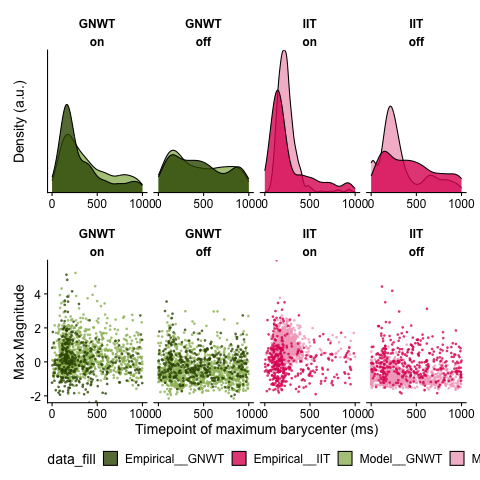

In [26]:
%%R -i all_raw_data_for_comparison

model_data_for_comparison <- all_raw_data_for_comparison %>%
    mutate(stimulus_presentation = factor(stimulus_presentation, levels=c("on", "off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    group_by(data_fill) %>%
    mutate(Max_Value_Z = (max - mean(max)) / sd(max)) %>%
    filter(Data_Type=="Model" & Noise==1)

empirical_data_for_comparison <- all_raw_data_for_comparison %>%
    mutate(stimulus_presentation = factor(stimulus_presentation, levels=c("on", "off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    group_by(data_fill) %>%
    mutate(Max_Value_Z = (max - mean(max)) / sd(max)) %>%
    filter(Data_Type=="Empirical")

bary_max_density_plot <- ggplot(mapping=aes(x=max_time, fill=data_fill)) +
  scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(data=model_data_for_comparison, alpha=0.8) +
    geom_density(data=empirical_data_for_comparison, alpha=0.8) +
    facet_wrap(Model ~ stimulus_presentation, scales="free_x", nrow=1) +
    scale_fill_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66")) +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- ggplot(mapping=aes(x=max_time, y=Max_Value_Z, color=data_fill)) +
  scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_point(data=model_data_for_comparison, stroke=0, alpha=0.8, size=1.25) +
    geom_point(data=empirical_data_for_comparison, stroke=0, alpha=0.8, size=1.25) +
    facet_wrap(Model ~ stimulus_presentation, scales="free_x", nrow=1) +
    scale_color_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66")) +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
      plot_layout(axis_titles = "collect", guides = "collect") &
      theme(legend.position="bottom") &
      scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))

# ggsave("../plots/modeling/Model_vs_empirical_barycenter_max_timing.svg", width=8, height=5, units='in', dpi=300)

In [27]:
%%R -i all_abs_data_for_comparison

model_data_for_comparison <- all_abs_data_for_comparison %>%
    mutate(stimulus_presentation = factor(stimulus_presentation, levels=c("on", "off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    group_by(data_fill) %>%
    mutate(Max_Value_Z = (max - mean(max)) / sd(max)) %>%
    filter(Data_Type=="Model" & Noise==1)

empirical_data_for_comparison <- all_abs_data_for_comparison %>%
    mutate(stimulus_presentation = factor(stimulus_presentation, levels=c("on", "off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    group_by(data_fill) %>%
    mutate(Max_Value_Z = (max - mean(max)) / sd(max)) %>%
    filter(Data_Type=="Empirical")

bary_max_density_plot <- ggplot(mapping=aes(x=max_time, fill=data_fill)) +
  scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(data=model_data_for_comparison, alpha=0.8) +
    geom_density(data=empirical_data_for_comparison, alpha=0.8) +
    facet_wrap(Model ~ stimulus_presentation, scales="free_x", nrow=1) +
    scale_fill_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66")) +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- ggplot(mapping=aes(x=max_time, y=Max_Value_Z, color=data_fill)) +
  scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_point(data=model_data_for_comparison, stroke=0, alpha=0.8, size=1.25) +
    geom_point(data=empirical_data_for_comparison, stroke=0, alpha=0.8, size=1.25) +
    facet_wrap(Model ~ stimulus_presentation, scales="free_x", nrow=1) +
    scale_color_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66")) +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
      plot_layout(axis_titles = "collect", guides = "collect") &
      theme(legend.position="bottom") &
      scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))

ggsave("../plots/modeling/Model_vs_empirical_barycenter_max_timing_abs_value.svg", width=8, height=5, units='in', dpi=300)

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


In [23]:
def kl_divergence_from_counts(P_counts, Q_counts, units="bits", num_bins=100, epsilon=1e-10):
    """
    Compute the Kullback-Leibler divergence between two discrete distributions
    given their observed counts (P_counts and Q_counts), with automatic binning.

    Args:
    P_counts (array-like): Observed counts for the first distribution.
    Q_counts (array-like): Observed counts for the second distribution.
    num_bins (int): The number of bins to use for both distributions.
    epsilon (float): Small value to avoid division by zero or log of zero.

    Returns:
    float: The KL divergence D(P || Q).
    """
    # The bins should be the same for both P and Q
    
    # Compute shared bin edges based on the range of both distributions
    min_val = min(np.min(P_counts), np.min(Q_counts))
    max_val = max(np.max(P_counts), np.max(Q_counts))
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)

    # Create histograms (bins) for both P and Q using the same bin edges
    P_hist, _ = np.histogram(P_counts, bins=bin_edges, density=True)
    Q_hist, _ = np.histogram(Q_counts, bins=bin_edges, density=True)
    
    # Normalize the histograms so they sum to 1 (convert to probability distributions)
    P_hist = P_hist / P_hist.sum()
    Q_hist = Q_hist / Q_hist.sum()

    # Clip values to avoid log(0) or division by zero
    P_hist = np.clip(P_hist, epsilon, 1)
    Q_hist = np.clip(Q_hist, epsilon, 1)

    # Compute KL divergence in bits or nats
    if units == "bits":
        kl_div = np.sum(P_hist * np.log2(P_hist / Q_hist))
    else:
        kl_div = np.sum(P_hist * np.log(P_hist / Q_hist))

    return kl_div


In [24]:
all_raw_data_for_comparison.query("Data_Type=='Model'").head()

SPI_stat,SPI,Data_Type,stimulus_type,relevance_type,subject_ID,stimulus_presentation,max,max_time,Model,Noise,sim_num
2000,bary-sq_euclidean,Model,NaN,NaN,NaN,off,5.169215,64.0,GNWT,1.0,0.0
2001,bary-sq_euclidean,Model,NaN,NaN,NaN,on,6.092397,538.0,GNWT,1.0,0.0
2002,bary-sq_euclidean,Model,NaN,NaN,NaN,off,6.248969,18.0,GNWT,1.0,1.0
2003,bary-sq_euclidean,Model,NaN,NaN,NaN,on,7.971120,148.0,GNWT,1.0,1.0
2004,bary-sq_euclidean,Model,NaN,NaN,NaN,off,7.871972,504.0,GNWT,1.0,2.0


In [25]:
# Compute the KL divergence between the model and empirical data
all_KL_results_list = []
all_WD_results_list = []
for model in ["GNWT", "IIT"]:
    # for noise_level in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    for noise_level in [1]:
        for stim_type in ['on', 'off']:
        
            # Subset data
            empirical_data_raw = all_raw_data_for_comparison.query("stimulus_presentation == @stim_type & Model == @model & Data_Type == 'Empirical'")['max_time']
            model_data_raw = all_raw_data_for_comparison.query("stimulus_presentation == @stim_type & Model == @model & Data_Type == 'Model' & Noise==@noise_level")['max_time']

            empirical_data_abs = all_abs_data_for_comparison.query("stimulus_presentation == @stim_type & Model == @model & Data_Type == 'Empirical'")['max_time']
            model_data_abs = all_abs_data_for_comparison.query("stimulus_presentation == @stim_type & Model == @model & Data_Type == 'Model' & Noise==@noise_level")['max_time']

            #### KL ####
            # Raw data
            this_model_noise_KL_raw = kl_divergence_from_counts(empirical_data_raw, model_data_raw, num_bins=100, units="bits")
            all_KL_results_list.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "Data_Type": ["Raw"], "KL_Divergence": [this_model_noise_KL_raw]}))

            # Absolute value data
            this_model_noise_KL_abs = kl_divergence_from_counts(empirical_data_abs, model_data_abs, num_bins=100, units="bits")
            all_KL_results_list.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "Data_Type": ["Abs"], "KL_Divergence": [this_model_noise_KL_abs]}))

            #### Wasserstein Distance ####
            # Raw data
            this_model_noise_WD_raw = wasserstein_distance(empirical_data_raw, model_data_raw)
            all_WD_results_list.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "Data_Type": ["Raw"], "WD": [this_model_noise_WD_raw]}))

            # Absolute value data
            this_model_noise_WD_abs = wasserstein_distance(empirical_data_abs, model_data_abs)
            all_WD_results_list.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "Data_Type": ["Abs"], "WD": [this_model_noise_WD_abs]}))

# Concatenate the results
all_KL_results = pd.concat(all_KL_results_list)
all_WD_results = pd.concat(all_WD_results_list)

# Merge the KL and WD results
all_stats_results = pd.merge(all_KL_results, all_WD_results, on=['Model', 'Stim', 'Noise', 'Data_Type'])
all_stats_results.query("Noise == 1").sort_values(['Data_Type', 'Model'])

,Model,Stim,Noise,Data_Type,KL_Divergence,WD
1,GNWT,on,1,Abs,0.386629,44.575617
3,GNWT,off,1,Abs,0.409843,28.326319
5,IIT,on,1,Abs,3.040061,82.594000
7,IIT,off,1,Abs,0.808682,63.468213
0,GNWT,on,1,Raw,0.390571,76.110872
2,GNWT,off,1,Raw,0.344397,18.642957
4,IIT,on,1,Raw,3.460554,94.925617
6,IIT,off,1,Raw,0.837294,117.725128


### How does the barycenter max timing distribute across noise levels from 0.5 to 1 SD?

In [ ]:
%%R -i all_abs_data_for_comparison,all_stats_results

plasma_colors <- viridis::inferno(6)[1:5]

all_abs_data_for_comparison %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, group=Noise, color=Noise)) +
    # Set density line alpha to 0.6
    geom_density(aes(color = Noise), alpha = 0.6, fill = NA, key_glyph = draw_key_path) +
    facet_grid(Model ~ Stim, scales='free') +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)")   +
    scale_color_gradientn(colors=plasma_colors) +
    guides(color=guide_legend(title="Noise Level (SD)", override.aes = list(linewidth = 3), nrow=1)) +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

# ggsave("../plots/modeling/Noise_model_vs_empirical_max_Euclidean_squared_barycenter.svg", width=5.5, height=4, units='in', dpi=300)

all_stats_results %>% 
    filter(Data_Type=="Abs") %>%
    ggplot(data=., mapping=aes  (x=Noise, y=KL_Divergence)) +
    geom_line(aes(group=Model), color='gray70') +
    geom_point(aes(color=Noise), size=2.5) +
    scale_color_gradientn(colors=plasma_colors) +
    facet_wrap(Model ~ Stim, scales="free") +
    theme(legend.position="none")
# ggsave("../plots/modeling/Noise_model_vs_empirical_DKL.svg", width=4.5, height=4, units='in', dpi=300)

In [ ]:
all_stats_results_irrel.query("Data_Type=='Raw' & Noise == 1")

## Robustness analysis: irrelevant rather than relevant non-target setting

In [18]:
# Irrelevant data
all_raw_data_for_comparison_irrel, all_abs_data_for_comparison_irrel = prep_empirical_model_data_for_comparison(all_time_resolved_barycenter_res, 
                                                                                                                relevance="Irrelevant", 
                                                                                                                barycenter_geometry="euclidean",
                                                                                                                  N_sims=1000)

In [ ]:
# Compute the KL divergence between the model and empirical data
all_KL_results_irrel_list = []
all_WD_results_irrel_list = []
for model in ["GNWT", "IIT"]:
    for noise_level in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        for stim_type in ['On', 'Off']:
        
            # Subset data
            empirical_data_raw = all_raw_data_for_comparison_irrel.query("Stim == @stim_type & Model == @model & Data_Type == 'Empirical'")['Max_Time']
            model_data_raw = all_raw_data_for_comparison_irrel.query("Stim == @stim_type & Model == @model & Data_Type == 'Model' & Noise==@noise_level")['Max_Time']

            empirical_data_abs = all_abs_data_for_comparison_irrel.query("Stim == @stim_type & Model == @model & Data_Type == 'Empirical'")['Max_Time']
            model_data_abs = all_abs_data_for_comparison_irrel.query("Stim == @stim_type & Model == @model & Data_Type == 'Model' & Noise==@noise_level")['Max_Time']

            #### KL ####
            # Raw data
            this_model_noise_KL_raw = kl_divergence_from_counts(empirical_data_raw, model_data_raw, num_bins=100, units="bits")
            all_KL_results_irrel_list.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "Data_Type": ["Raw"], "KL_Divergence": [this_model_noise_KL_raw]}))

            # Absolute value data
            this_model_noise_KL_abs = kl_divergence_from_counts(empirical_data_abs, model_data_abs, num_bins=100, units="bits")
            all_KL_results_irrel_list.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "Data_Type": ["Abs"], "KL_Divergence": [this_model_noise_KL_abs]}))

            #### Wasserstein Distance ####
            # Raw data
            this_model_noise_WD_raw = wasserstein_distance(empirical_data_raw, model_data_raw)
            all_WD_results_irrel_list.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "Data_Type": ["Raw"], "WD": [this_model_noise_WD_raw]}))

            # Absolute value data
            this_model_noise_WD_abs = wasserstein_distance(empirical_data_abs, model_data_abs)
            all_WD_results_irrel_list.append(pd.DataFrame({"Model": [model], "Stim": [stim_type], "Noise": [noise_level], "Data_Type": ["Abs"], "WD": [this_model_noise_WD_abs]}))

# Concatenate the results
all_KL_results_irrel = pd.concat(all_KL_results_irrel_list)
all_WD_results_irrel = pd.concat(all_WD_results_irrel_list)

# Merge the KL and WD results
all_stats_results_irrel = pd.merge(all_KL_results_irrel, all_WD_results_irrel, on=['Model', 'Stim', 'Noise', 'Data_Type'])
all_stats_results_irrel.query("Noise == 1").sort_values(['Data_Type', 'Model'])

In [ ]:
%%R -i all_abs_data_for_comparison_irrel

bary_max_density_plot <- all_abs_data_for_comparison_irrel %>%
    filter(Data_Type=="Empirical" | Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    mutate(data_fill = factor(data_fill, levels=rev(c("Empirical__IIT", "Model__IIT", 
                                                      "Empirical__GNWT", "Model__GNWT")))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, fill=data_fill)) +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(alpha=0.8) +
    facet_wrap(Model ~ Stim, scales="free_x", nrow=1) +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    scale_fill_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66"))  +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- all_abs_data_for_comparison_irrel %>% 
    filter(Data_Type=="Empirical" | Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    mutate(data_fill = factor(data_fill, levels=rev(c("Empirical__IIT", "Model__IIT", 
                                                      "Empirical__GNWT", "Model__GNWT")))) %>%
    group_by(data_fill) %>%
    mutate(Max_Value_Z = (Max_Value - mean(Max_Value)) / sd(Max_Value)) %>%
    ggplot(data=., mapping=aes(x=Max_Time, y=Max_Value_Z, color=data_fill)) +
    geom_point(stroke=0, alpha=0.8, size=1.25) +
    facet_wrap(Model ~ Stim, scales="free_x", nrow=1) +
    scale_color_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66"))  +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
      plot_layout(axis_titles = "collect", guides = "collect") &
      theme(legend.position="bottom") &
      scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))

ggsave("../plots/modeling/Model_vs_empirical_barycenter_max_timing_irrelevant_abs.svg", width=8, height=5, units='in', dpi=300)

In [ ]:
%%R -i all_raw_data_for_comparison_irrel

bary_max_density_plot <- all_raw_data_for_comparison_irrel %>%
    filter(Data_Type=="Empirical" | Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    mutate(data_fill = factor(data_fill, levels=rev(c("Empirical__IIT", "Model__IIT", 
                                                      "Empirical__GNWT", "Model__GNWT")))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, fill=data_fill)) +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(alpha=0.8) +
    facet_wrap(Model ~ Stim, scales="free_x", nrow=1) +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    scale_fill_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66"))  +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- all_raw_data_for_comparison_irrel %>% 
    filter(Data_Type=="Empirical" | Noise==1) %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off")),
           data_fill = glue("{Data_Type}__{Model}")) %>%
    mutate(data_fill = factor(data_fill, levels=rev(c("Empirical__IIT", "Model__IIT", 
                                                      "Empirical__GNWT", "Model__GNWT")))) %>%
    group_by(data_fill) %>%
    mutate(Max_Value_Z = (Max_Value - mean(Max_Value)) / sd(Max_Value)) %>%
    ggplot(data=., mapping=aes(x=Max_Time, y=Max_Value_Z, color=data_fill)) +
    geom_point(stroke=0, alpha=0.8, size=1.25) +
    facet_wrap(Model ~ Stim, scales="free_x", nrow=1) +
    scale_color_manual(values=c("Empirical__IIT" = "#df2563", "Model__IIT" = "#f3abc3",
                               "Empirical__GNWT" = "#365400", "Model__GNWT" = "#9cba66"))  +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
      plot_layout(axis_titles = "collect", guides = "collect") &
      theme(legend.position="bottom") &
      scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))

ggsave("../plots/modeling/Model_vs_empirical_barycenter_max_timing_irrelevant_raw.svg", width=8, height=5, units='in', dpi=300)

In [ ]:
%%R -i all_raw_data_for_comparison,all_abs_data_for_comparison,all_abs_data_for_comparison_irrel,all_stats_results,all_stats_results_irrel

plasma_colors <- viridis::inferno(6)[1:5]


######################### Absolute value data, irrelevant setting #########################
all_abs_data_for_comparison_irrel %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, group=Noise, color=Noise)) +
    # Set density line alpha to 0.6
    geom_density(aes(color = Noise), alpha = 0.6, fill = NA, key_glyph = draw_key_path) +
    facet_grid(Model ~ Stim, scales='free') +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)")   +
    scale_color_gradientn(colors=plasma_colors) +
    guides(color=guide_legend(title="Noise Level (SD)", override.aes = list(linewidth = 3), nrow=1)) +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))
ggsave("../plots/modeling/Noise_model_vs_empirical_abs_irrel_max_Euclidean_squared_barycenter.svg", width=5.5, height=4, units='in', dpi=300)

all_stats_results_irrel %>%
    filter(Data_Type=="Abs") %>%
    ggplot(data=., mapping=aes(x=Noise, y=KL_Divergence)) +
    geom_line(aes(group=Model), color='gray70') +
    geom_point(aes(color=Noise), size=2.5) +
    scale_color_gradientn(colors=plasma_colors) +
    facet_wrap(Model ~ Stim, scales="free") +
    theme(legend.position="none")
ggsave("../plots/modeling/Noise_model_vs_empirical_abs_irrel_DKL.svg", width=4.5, height=4, units='in', dpi=300)

######################### Raw data, relevant non-target setting #########################
all_raw_data_for_comparison %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, group=Noise, color=Noise)) +
    # Set density line alpha to 0.6
    geom_density(aes(color = Noise), alpha = 0.6, fill = NA, key_glyph = draw_key_path) +
    facet_grid(Model ~ Stim, scales='free') +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)")   +
    scale_color_gradientn(colors=plasma_colors) +
    guides(color=guide_legend(title="Noise Level (SD)", override.aes = list(linewidth = 3), nrow=1)) +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))
ggsave("../plots/modeling/Noise_model_vs_empirical_raw_max_Euclidean_squared_barycenter.svg", width=5.5, height=4, units='in', dpi=300)

all_stats_results %>% 
    filter(Data_Type=="Raw") %>%
    ggplot(data=., mapping=aes(x=Noise, y=KL_Divergence)) +
    geom_line(aes(group=Model), color='gray70') +
    geom_point(aes(color=Noise), size=2.5) +
    scale_color_gradientn(colors=plasma_colors) +
    facet_wrap(Model ~ Stim, scales="free") +
    theme(legend.position="none")
ggsave("../plots/modeling/Noise_model_vs_empirical_raw_DKL.svg", width=4.5, height=4, units='in', dpi=300)

######################### Raw data, irrelevant setting #########################
all_raw_data_for_comparison_irrel %>%
    mutate(Stim = factor(Stim, levels=c("On", "Off"))) %>%
    ggplot(data=., mapping=aes(x=Max_Time, group=Noise, color=Noise)) +
    # Set density line alpha to 0.6
    geom_density(aes(color = Noise), alpha = 0.6, fill = NA, key_glyph = draw_key_path) +
    facet_grid(Model ~ Stim, scales='free') +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)")   +
    scale_color_gradientn(colors=plasma_colors) +
    guides(color=guide_legend(title="Noise Level (SD)", override.aes = list(linewidth = 3), nrow=1)) +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="bottom",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

ggsave("../plots/modeling/Noise_model_vs_empirical_raw_irrel_max_Euclidean_squared_barycenter.svg", width=5.5, height=4, units='in', dpi=300)

all_stats_results_irrel %>%
    filter(Data_Type=="Raw") %>%
    ggplot(data=., mapping=aes(x=Noise, y=KL_Divergence)) +
    geom_line(aes(group=Model), color='gray70') +
    geom_point(aes(color=Noise), size=2.5) +
    scale_color_gradientn(colors=plasma_colors) +
    facet_wrap(Model ~ Stim, scales="free") +
    theme(legend.position="none")
ggsave("../plots/modeling/Noise_model_vs_empirical_raw_irrel_DKL.svg", width=4.5, height=4, units='in', dpi=300)
